In [210]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from numpy.linalg import inv

In [211]:
class RBFKernel:
    def __init__(self, signal_variance = 2, length_scale = 2) -> None:
        self.signal_variance = signal_variance
        self.length_scale = length_scale

    def transform(self, x1, x2):
        return self.signal_variance**2 * np.exp(-((x1-x2)**2)/2*self.length_scale**2)
    
    def set_params(self, signal_variance, length_scale):
        self.signal_variance = signal_variance
        self.length_scale = length_scale
        return self

In [212]:
def mean(X):
    # We assume 0 mean
    return np.zeros(shape=len(X))

def covariance(X1, X2, kernel):
    cov = np.zeros(shape=(len(X1), len(X2)))

    for i in range(len(X1)):
        for j in range(len(X2)):
            cov[i][j] = kernel.transform(X1[i], X2[j])
            
    return cov


In [213]:
n_train = 30
# n_test = 20

X_train = sorted(np.random.uniform(low=-5, high=5, size=n_train))
y_train = np.sin(X_train)

X_test = np.linspace(start=-6, stop=6, num=100)

In [214]:
class GP:
    def __init__(self, kernel) -> None:
        self.kernel = kernel
        pass
    
    def train(self, X_train, y_train, X_test):
        noise_variance = 0
        # signal_variance = [0.05, 0.1, 0.3, 0.5, 1, 1.5, 2, 2.5]
        # length_scale = [0.07, 0.2, 0.5, 1, 1.5, 2, 2.5]
        # noise_variance = [0, 0.3, 0.6, 0.9, 1.2, 1.5]
        
        # best_signal_variance = 2
        # best_length_scale = 2
        # best_noise_variance = 0
        # best_likelihood = -100000
        
        # # Find best hyperparameters
        # for sv in signal_variance:
        #     for ls in length_scale:
        #         for nv in noise_variance:
        #             self.kernel = self.kernel.set_params(sv, ls)
        #             cov_X_X = covariance(X_train, X_train, self.kernel)
        #             cov_Xt_X = covariance(X_test, X_train, self.kernel)
        #             cov_Xt_Xt = covariance(X_test, X_test, self.kernel)
        #             jitter = np.eye(len(cov_X_X)) * 1e-6
        #             k_inv = inv(cov_X_X + nv*np.identity(n=len(cov_X_X))+ jitter)

        #             # mu =  mean(X_test) + cov_Xt_X @ k_inv @ (y_train-mean(X_train))
        #             # sigma = cov_Xt_Xt - cov_Xt_X @ k_inv @ cov_Xt_X.T

        #             ll = self.prob(y_train, mean(X_train), cov_X_X + nv*np.identity(n=len(cov_X_X)))
                    
        #             if ll > best_likelihood:
        #                 best_signal_variance = sv
        #                 best_length_scale = ls
        #                 best_noise_variance = nv
        #                 best_likelihood = ll
        
        # # Return results based on best hyperparameters
        # self.kernel = self.kernel.set_params(best_signal_variance, best_length_scale)
        cov_X_X = covariance(X_train, X_train, self.kernel)
        cov_Xt_X = covariance(X_test, X_train, self.kernel)
        cov_Xt_Xt = covariance(X_test, X_test, self.kernel)
        k_inv = inv(cov_X_X + noise_variance*np.identity(n=len(cov_X_X)))

        mu =  mean(X_test) + cov_Xt_X @ k_inv @ (y_train-mean(X_train))
        sigma = cov_Xt_Xt - cov_Xt_X @ k_inv @ cov_Xt_X.T
        
        # print(self.prob(y_train, mean(X_train), cov_X_X + best_noise_variance*np.identity(n=len(cov_X_X))))
        #print(self.log_likelihood(cov_X_X, noise_variance*np.identity(n=len(cov_X_X)), y_train, mean(X_train), k_inv))
        
        return mu, sigma#, best_signal_variance, best_length_scale, best_noise_variance
    
    def log_likelihood(self, cov_X_X, noise_cov, y_train, mean_X, k_inv):
        return (-0.5 * np.log(np.linalg.det(cov_X_X + noise_cov))+1e-6) - (0.5 * (y_train-mean_X).T @ k_inv @(y_train-mean_X)) - (len(y_train)/2) * np.log(2*np.pi)

    def prob(self, y_train, mean_x, noise_cov):
        y = multivariate_normal.rvs(mean=mean_x, cov=noise_cov)
        jitter = np.eye(len(noise_cov)) * 1e-6
        prob = multivariate_normal.pdf(y_train, mean=mean_x, cov=noise_cov + jitter)
        return prob

mod = GP(RBFKernel())
mu, sigma = mod.train(X_train, y_train, X_test)
# mu, sigma, best_signal_variance, best_length_scale, best_noise_variance = mod.train(X_train, y_train, X_test)
# best_signal_variance, best_length_scale, best_noise_variance


C:\Users\asing\AppData\Local\Temp/ipykernel_14864/4162457678.py:13: RuntimeWarning: invalid value encountered in sqrt
  ax1.fill_between(X_test, mu-2*np.sqrt(np.diag(sigma)), mu+2*np.sqrt(np.diag(sigma)), color='red', alpha=0.15, label='$2 \sigma_{2|1}$')


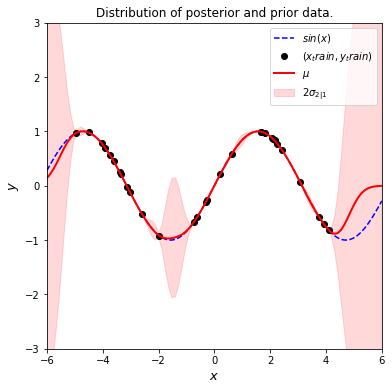

In [215]:
# Plot the postior distribution and some samples
fig, ax1 = plt.subplots(
    nrows = 1, ncols=1, figsize=(6, 6))

# Plot the correct distribution
x_space = np.linspace(start=-6, stop=6, num=1000)
y_space = np.sin(x_space)
ax1.plot(x_space, y_space, 'b--', label='$sin(x)$')
ax1.plot(X_train, y_train, 'ko', linewidth=2, label='$(x_train, y_train)$')

# Plot the posterior
ax1.plot(X_test, mu, 'r-', lw=2, label='$\mu$')
ax1.fill_between(X_test, mu-2*np.sqrt(np.diag(sigma)), mu+2*np.sqrt(np.diag(sigma)), color='red', alpha=0.15, label='$2 \sigma_{2|1}$')


ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([-6, 6, -3, 3])
ax1.legend()

Observation: Too many training points will mess up the graph